In [1]:
#importing necessary packages
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense,Reshape
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse


import os

from subprocess import check_output
print(check_output(["ls", "../input/fold1/fold1"]).decode("utf8"))

Using TensorFlow backend.


test
train



In [2]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--plot", type=str, default="plot.png",
help="path to output loss/accuracy plot")
args = vars(ap.parse_args())


usage: ipykernel_launcher.py [-h] [-p PLOT]
ipykernel_launcher.py: error: unrecognized arguments: -f /tmp/tmpag1jbpg9.json


SystemExit: 2

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3333: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/fold1/fold1/test/200X"))
print(os.listdir("../input/fold1/fold1/train/200X"))

import fnmatch,os
Test_M = len(fnmatch.filter(os.listdir("../input/fold1/fold1/test/200X/M_200X"),'*.png'))
print("test_M:  ",Test_M)
Test_B=len(fnmatch.filter(os.listdir("../input/fold1/fold1/test/200X/B_200X"),'*.png'))
print("test_B:   ",Test_B)
total_Test=Test_M+Test_B
print("TEST:  ",total_Test)
Train_M=len(fnmatch.filter(os.listdir("../input/fold1/fold1/train/200X/M_200X"),'*.png'))
print("train_M:  ",Train_M)
Train_B=len(fnmatch.filter(os.listdir("../input/fold1/fold1/train/200X/B_200X"),'*.png'))
print("train_B:  ",Train_B)
total_train=Train_B+Train_M
print("Train:    ",total_train)
# Any results you write to the current directory are saved as output.



['B_200X', 'M_200X']
['B_200X', 'M_200X']
test_M:   489
test_B:    255
TEST:   744
train_M:   901
train_B:   368
Train:     1269


In [4]:
EPOCHS = 20
INIT_LR = 1e-5
BS = 8
default_image_size = tuple((700,460))
image_size = 0
width=700
height=460
depth=3

In [5]:
#def convert_image_to_array(image_dir):
    #try:
        #image = cv2.imread(image_dir)
        #if image is not None :
            #image = cv2.resize(image, default_image_size)   
            #return img_to_array(image)
        #else :
            #return np.array([])
    #except Exception as e:
        #print(f"Error : {e}")
        #return None

In [6]:

train_datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1,rescale = 1./255, ##noramlaize gareko
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale = 1./255) 

#train = train_datagen.flow_from_directory('../input/fold1/fold1/train/40X',
                                                 #class_mode = 'binary')
train = train_datagen.flow_from_directory('../input/fold1/fold1/train/200X',
                                            class_mode="binary",
                                            target_size=(460, 700),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=BS)

#print(type(train))

test= test_datagen.flow_from_directory('../input/fold1/fold1/test/200X',
                                        class_mode="binary",
                                        target_size=(460, 700),
                                        color_mode="rgb",
                                        shuffle=True,
                                        batch_size=BS)

#validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        #target_size=(460,700),
                                                        #batch_size=batch_size,
                                                        #class_mode='categorical')
#train=train.reshape(-1,700,460,1)



Found 1269 images belonging to 2 classes.
Found 744 images belonging to 2 classes.


In [7]:

from keras import layers
from keras.models import Model

optss = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
def alexnet(in_shape=(460,700,3), n_classes=2, opt=optss):
    in_layer = layers.Input(in_shape)
    conv1 = layers.Conv2D(256,(3,3),strides=2,input_shape=(460,700,3),activation='relu')(in_layer)
    
    pool1 = layers.MaxPool2D(2, 2)(conv1)
    conv2 = layers.Conv2D(128,(3,3),strides=2,padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPool2D(2, 2)(conv2)
    conv3 = layers.Conv2D(64,(3,3),strides=2,padding='same', activation='relu')(pool2)
    conv4 = layers.Conv2D(32,(3,3),strides=2,padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPool2D(2, 2)(conv4)
    flattened = layers.Flatten()(pool3)
    dense1 = layers.Dense(128,activation='relu')(flattened)
    drop1 = layers.Dropout(0.25)(dense1)
    dense2 = layers.Dense(128,activation='relu')(drop1)
    drop2 = layers.Dropout(0.25)(dense2)
    preds = layers.Dense(n_classes, activation='softmax')(drop2)
    #print("hi",preds)
    model = Model(in_layer, preds)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model

#def model1():
    #model1 = Sequential()
    #model1.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(700,460,3)))
    #model1.add(Conv2D(32, kernel_size=3, activation='relu'))
    #model1.add(Flatten())
    #model1.add(Dense(10, activation='softmax'))
    #model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #return model1

In [8]:
model = alexnet()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 460, 700, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 229, 349, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 114, 174, 256)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 87, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 43, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 22, 64)        73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 11, 32)         18464     
__________

In [9]:

 ''' history=model.fit_generator(train,
                        #steps_per_epoch = 1250,
                        steps_per_epoch = 157,
                        epochs =EPOCHS,
                        validation_data = test,
                        validation_steps=94)'''

H = model.fit_generator(
	train,
	steps_per_epoch=total_train // BS,
	validation_data=test,
	validation_steps=total_Test // BS,
	epochs=EPOCHS)



Epoch 1/20
158/158 [==============================] - 118s 750ms/step - loss: 0.6384 - acc: 0.6930 - val_loss: 0.6396 - val_acc: 0.6573
Epoch 2/20
158/158 [==============================] - 100s 634ms/step - loss: 0.6038 - acc: 0.7071 - val_loss: 0.6439 - val_acc: 0.6573
Epoch 3/20
158/158 [==============================] - 99s 628ms/step - loss: 0.5922 - acc: 0.7106 - val_loss: 0.6143 - val_acc: 0.6573
Epoch 4/20
158/158 [==============================] - 102s 645ms/step - loss: 0.5661 - acc: 0.7087 - val_loss: 0.5919 - val_acc: 0.6573
Epoch 5/20
158/158 [==============================] - 99s 624ms/step - loss: 0.5408 - acc: 0.7123 - val_loss: 0.5412 - val_acc: 0.6573
Epoch 6/20
158/158 [==============================] - 96s 610ms/step - loss: 0.5074 - acc: 0.7313 - val_loss: 0.5044 - val_acc: 0.6828
Epoch 7/20
158/158 [==============================] - 97s 614ms/step - loss: 0.4826 - acc: 0.7783 - val_loss: 0.4669 - val_acc: 0.8481
Epoch 8/20
158/158 [==============================] 

In [10]:
print("[INFO] evaluating network...")
test.reset()
predIdxs = model.predict_generator(test,
steps=(total_Test // BS) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test.classes, predIdxs,
 target_names=test.class_indices.keys()))


[INFO] evaluating network...


ValueError: Found input variables with inconsistent numbers of samples: [744, 752]

In [11]:

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

NameError: name 'test_dir' is not defined

In [12]:

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(test.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

ValueError: Found input variables with inconsistent numbers of samples: [744, 752]

NameError: name 'args' is not defined

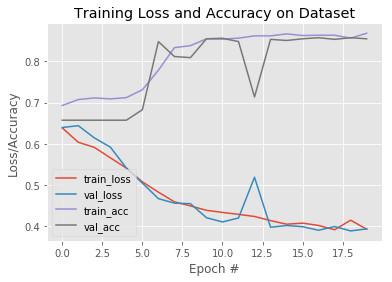

In [13]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

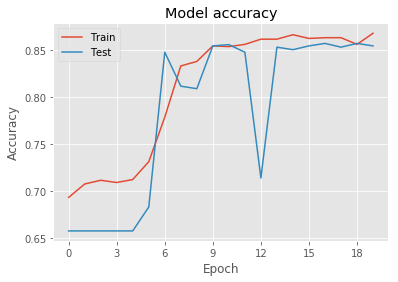

In [14]:
#test train accuracy vs epoch
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(H.history['acc']) 
plt.plot(H.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


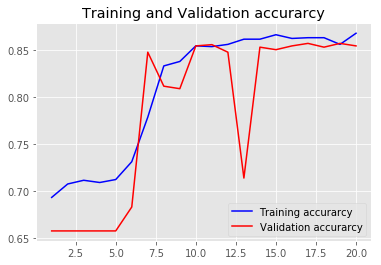

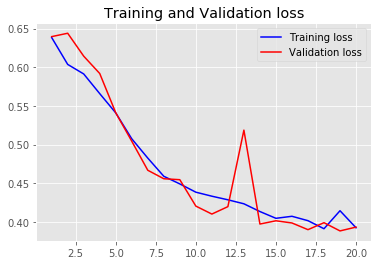

In [15]:
acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

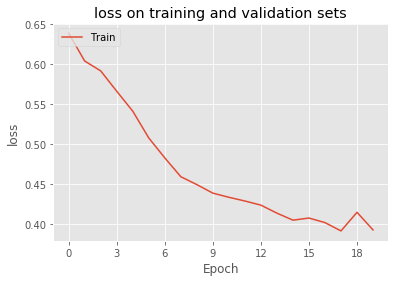

In [16]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(H.history['loss'])
plt.title('loss on training and validation sets')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


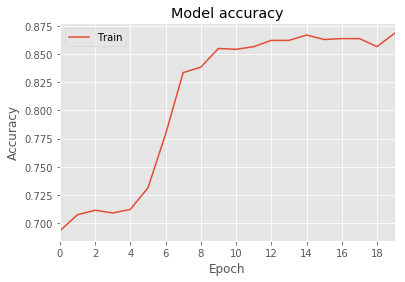

In [17]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.margins(x=0)

# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

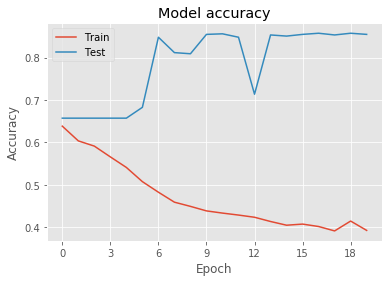

In [18]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(H.history['loss'])
plt.plot(H.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [19]:
print("[INFO] calculating model accuracy")
scores=model.evaluate(train,test)
printf("test accuracy:{scores[1]*100}")

[INFO] calculating model accuracy


AttributeError: 'DirectoryIterator' object has no attribute 'ndim'

In [20]:
model.save('hamromodel.h5')